<a href="https://colab.research.google.com/github/Trisha-Sarwade/Yelp_Data_Analysis/blob/main/nmf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade gensim

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [ ]:
# Run the utilty functions from the seperate notebook
#%run nlp_topic_utils.ipynb

### TODO Add your file path ###
file_path = '/content/drive/MyDrive/yelp_dataset/final_data_yelp2.csv'
file_name = 'final_data_yelp2.csv'

# Load the articles
df = pd.read_csv("/content/drive/MyDrive/yelp_dataset/final_data_yelp2.csv")

print(df.shape)
df.head()

(197949, 22)


,Unnamed: 0,Unnamed: 0.1,business_id,city,state_x,user_id,review_stars,useful_x,text,date,useful_y,fans,Smogscore,review_word_count,Polarity,Analysis_TextBlob,Vader Sentiment,Vader Analysis,fips,cases,deaths,label
0,0,0,uexKxrLmPO5iaXRT9TvWqQ,Portland,OR,1eSNY9Csb9ajO7__ci2vTA,3.0,0.0,Yes I am a fan of the food Ive tried more ...,2019-01-01,0.0,0.0,13.4,251.0,0.050208,Positive,0.7723,Positive,0.0,0.0,0.0,1.0
1,1,1,b4PgITSqSWoPhyJ-Mjko7Q,Portland,OR,KYCpm1B9eIIgbPatCIcVkg,4.0,0.0,Im not a bubble tea connoisseur but Ive had it...,2019-01-01,328.0,6.0,0.0,46.0,0.263889,Positive,0.8519,Positive,0.0,0.0,0.0,1.0
2,2,2,2EJpVjliJ6Ceijbz9HSpeQ,Portland,OR,f1lLNjrLk4ETU2t_N7fHbA,5.0,1.0,Fantastic authentic Italian food the pinsa ha...,2019-01-01,8.0,0.0,12.2,74.0,0.360000,Positive,0.9307,Positive,0.0,0.0,0.0,1.0
3,3,3,7m_Tj6xC5CjulQ-6Wucdpw,Portland,OR,uOSQbOnLRlAuWfCSCwQFnA,5.0,0.0,Good food very authentic The owner is pretty f...,2019-01-01,1.0,0.0,6.4,16.0,0.425000,Positive,0.9169,Positive,0.0,0.0,0.0,1.0
4,4,4,DgvT9AiuePR8Z0SKV5BFvw,Portland,OR,bSTMk_GXsPE93COgqUDnMg,4.0,0.0,The service is outstanding and the pasta is go...,2019-01-01,0.0,0.0,8.8,39.0,0.450000,Positive,0.9217,Positive,0.0,0.0,0.0,1.0


In [ ]:
# Get the word count
df['word_count'] = df['text'].apply(word_count)
df['word_count'].mean()

90.02175812961924

In [ ]:
# Process the text
df['processed_text'] = df['text'].apply(process_text)
df.head()

,Unnamed: 0,Unnamed: 0.1,business_id,city,state_x,user_id,review_stars,useful_x,text,date,useful_y,fans,Smogscore,review_word_count,Polarity,Analysis_TextBlob,Vader Sentiment,Vader Analysis,fips,cases,deaths,label,word_count,processed_text
0,0,0,uexKxrLmPO5iaXRT9TvWqQ,Portland,OR,1eSNY9Csb9ajO7__ci2vTA,3.0,0.0,Yes I am a fan of the food Ive tried more ...,2019-01-01,0.0,0.0,13.4,251.0,0.050208,Positive,0.7723,Positive,0.0,0.0,0.0,1.0,268,"[yes, fan, food, ive, tri, chines, american, r..."
1,1,1,b4PgITSqSWoPhyJ-Mjko7Q,Portland,OR,KYCpm1B9eIIgbPatCIcVkg,4.0,0.0,Im not a bubble tea connoisseur but Ive had it...,2019-01-01,328.0,6.0,0.0,46.0,0.263889,Positive,0.8519,Positive,0.0,0.0,0.0,1.0,48,"[im, bubbl, tea, connoisseur, ive, coupl, plac..."
2,2,2,2EJpVjliJ6Ceijbz9HSpeQ,Portland,OR,f1lLNjrLk4ETU2t_N7fHbA,5.0,1.0,Fantastic authentic Italian food the pinsa ha...,2019-01-01,8.0,0.0,12.2,74.0,0.360000,Positive,0.9307,Positive,0.0,0.0,0.0,1.0,75,"[fantast, authent, italian, food, pinsa, crunc..."
3,3,3,7m_Tj6xC5CjulQ-6Wucdpw,Portland,OR,uOSQbOnLRlAuWfCSCwQFnA,5.0,0.0,Good food very authentic The owner is pretty f...,2019-01-01,1.0,0.0,6.4,16.0,0.425000,Positive,0.9169,Positive,0.0,0.0,0.0,1.0,16,"[good, food, veri, authent, owner, pretti, fri..."
4,4,4,DgvT9AiuePR8Z0SKV5BFvw,Portland,OR,bSTMk_GXsPE93COgqUDnMg,4.0,0.0,The service is outstanding and the pasta is go...,2019-01-01,0.0,0.0,8.8,39.0,0.450000,Positive,0.9217,Positive,0.0,0.0,0.0,1.0,39,"[servic, outstand, pasta, good, strict, pasta,..."


In [ ]:
# Descriptive statistics for word count
df['word_count'].describe()

count    197949.000000
mean         90.021758
std          80.864992
min           1.000000
25%          37.000000
50%          65.000000
75%         115.000000
max         983.000000
Name: word_count, dtype: float64

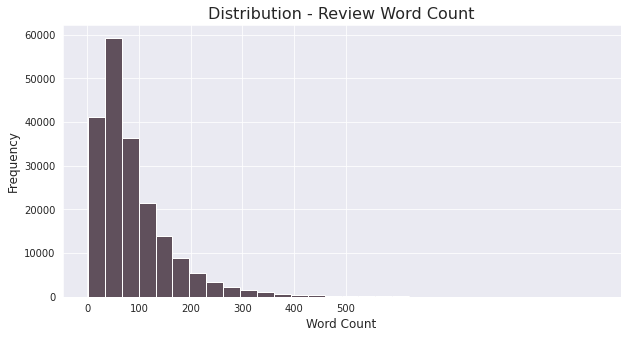

In [ ]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    df['word_count'],
    bins=30,
    color='#60505C'
)

plt.title('Distribution - Review Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(np.arange(0, 70000,10000))
plt.xticks(np.arange(0, 600, 100))

file_name = 'hist'

fig.savefig(
    '/content/drive/MyDrive/yelp_dataset/final_data_yelp2.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


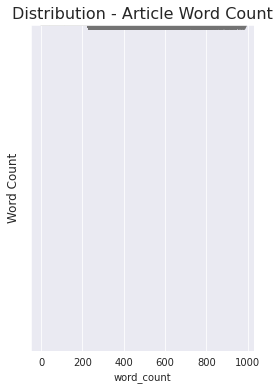

In [ ]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4,6))

sns.boxplot(
    df['word_count'],
    orient='v',
    width=0.5,
    color='#ff8080'
)

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Article Word Count', fontsize=16)
plt.yticks(np.arange(0, 70000, 1))

file_name = 'box_plot'

fig.savefig(
    '/content/drive/MyDrive/yelp_dataset/final_data_yelp2.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [ ]:
# Get the top 20 most common words among all the articles
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)


In [ ]:
top_20

,word,frequency
0,food,121097
1,place,97979
2,good,95761
3,order,89646
4,great,79942
5,veri,67109
6,time,66016
7,servic,59311
8,just,57056
9,tri,51424


In [ ]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

90583

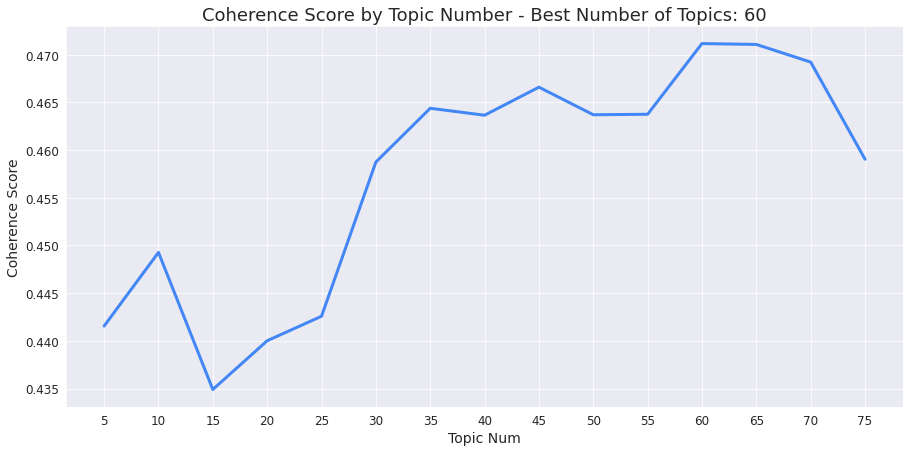

In [ ]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

file_name = 'c_score'

#fig.savefig(
   # file_path + file_name + '.png',
    #dpi=fig.dpi,
    #bbox_inches='tight'
#)

plt.show()

In [ ]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


In [ ]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


,0,1,2,3,4,5,6,7,topics
0,ask,didnt,came,told,minut,server,check,manag,ask didnt came told minut server check manag
1,great,great food,food great,great servic,servic great,great place,atmospher,great atmospher,great food servic place atmospher
2,chicken,fri chicken,waffl,chicken sandwich,wing,chicken waffl,spici,sauc,chicken fri waffl sandwich wing spici sauc
3,pizza,crust,slice,best pizza,pie,pepperoni,pizza place,good pizza,pizza crust slice best pie pepperoni place good
4,locat,park,hotel,room,store,street,stay,conveni,locat park hotel room store street stay conveni


In [ ]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()

,topic_num,topics
0,0,ask didnt came told minut server check manag
1,1,great food servic place atmospher
2,2,chicken fri waffl sandwich wing spici sauc
3,3,pizza crust slice best pie pepperoni place good
4,4,locat park hotel room store street stay conveni


In [ ]:
merged_topic

,topic_num,topics
0,47,portland visit favorit stop trip place restaur
1,11,tea boba milk bubbl sweet sugar
2,3,pizza crust slice best pie pepperoni place good
3,19,veri good friend food nice tasti staff
4,45,salad lunch dress fresh caesar bowl green
...,...,...
197944,57,spot favorit hit new great neighborhood
197945,34,tri menu place everyth look want ive
197946,36,breakfast egg brunch toast biscuit burrito bac...
197947,41,nice veri super realli place atmospher littl


In [ ]:
df

,Unnamed: 0,Unnamed: 0.1,business_id,city,state_x,user_id,review_stars,useful_x,text,date,useful_y,fans,Smogscore,review_word_count,Polarity,Analysis_TextBlob,Vader Sentiment,Vader Analysis,fips,cases,deaths,label,word_count,processed_text,resid
0,0,0,uexKxrLmPO5iaXRT9TvWqQ,Portland,OR,1eSNY9Csb9ajO7__ci2vTA,3.0,0.0,Yes I am a fan of the food Ive tried more ...,2019-01-01,0.0,0.0,13.4,251.0,0.050208,Positive,0.7723,Positive,0.0,0.0,0.0,1.0,268,"[yes, fan, food, ive, tri, chines, american, r...",0.928888
1,1,1,b4PgITSqSWoPhyJ-Mjko7Q,Portland,OR,KYCpm1B9eIIgbPatCIcVkg,4.0,0.0,Im not a bubble tea connoisseur but Ive had it...,2019-01-01,328.0,6.0,0.0,46.0,0.263889,Positive,0.8519,Positive,0.0,0.0,0.0,1.0,48,"[im, bubbl, tea, connoisseur, ive, coupl, plac...",0.873437
2,2,2,2EJpVjliJ6Ceijbz9HSpeQ,Portland,OR,f1lLNjrLk4ETU2t_N7fHbA,5.0,1.0,Fantastic authentic Italian food the pinsa ha...,2019-01-01,8.0,0.0,12.2,74.0,0.360000,Positive,0.9307,Positive,0.0,0.0,0.0,1.0,75,"[fantast, authent, italian, food, pinsa, crunc...",0.938841
3,3,3,7m_Tj6xC5CjulQ-6Wucdpw,Portland,OR,uOSQbOnLRlAuWfCSCwQFnA,5.0,0.0,Good food very authentic The owner is pretty f...,2019-01-01,1.0,0.0,6.4,16.0,0.425000,Positive,0.9169,Positive,0.0,0.0,0.0,1.0,16,"[good, food, veri, authent, owner, pretti, fri...",0.926724
4,4,4,DgvT9AiuePR8Z0SKV5BFvw,Portland,OR,bSTMk_GXsPE93COgqUDnMg,4.0,0.0,The service is outstanding and the pasta is go...,2019-01-01,0.0,0.0,8.8,39.0,0.450000,Positive,0.9217,Positive,0.0,0.0,0.0,1.0,39,"[servic, outstand, pasta, good, strict, pasta,...",0.896940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197944,197944,197944,BO4Usu_YSE7jlmchGMeVcw,Boston,MA,d3-SRpRr8SX2TZNOv4_dqg,4.0,0.0,I have to admit Shin Hakata Ramen was truly im...,2021-01-28,2.0,0.0,10.1,45.0,0.650000,Positive,0.9755,Positive,25025.0,70398.0,1548.0,1.0,45,"[admit, shin, hakata, ramen, truli, impress, a...",0.925407
197945,197945,197945,-WG2sv6ApNh1fa7ot-QAEA,Boston,MA,VZDjY7dU8gmraqr3oRCj-A,5.0,0.0,The BEST Rueben in Boston Hands down And I hav...,2021-01-28,1.0,0.0,6.4,27.0,0.250000,Positive,0.4995,Neutral,25025.0,70398.0,1548.0,1.0,27,"[best, rueben, boston, hand, tri, lot, rueben,...",0.960826
197946,197946,197946,EbUZhM4fLpsWQ8fpBhhgEQ,Boston,MA,RcAvNzBP3e9TxZZpfpohOA,5.0,0.0,Mike Pattys is such a cool neighborhood gem I...,2021-01-28,0.0,0.0,10.8,42.0,0.242857,Positive,0.9521,Positive,25025.0,70398.0,1548.0,1.0,43,"[mike, patti, cool, neighborhood, gem, im, thr...",0.963307
197947,197947,197947,IqyqfQFnBsOIReGrcgaYhA,Boston,MA,DJctK3XMg_8-zFZYY8puKA,2.0,0.0,Store is a little hard to find since it is hid...,2021-01-28,1.0,0.0,0.0,32.0,-0.038889,Negative,0.1761,Neutral,25025.0,70398.0,1548.0,1.0,32,"[store, littl, hard, sinc, hidden, littl, food...",0.967051


In [ ]:
df2=pd.concat([df, merged_topic], axis=1)

In [ ]:
df2

,Unnamed: 0,Unnamed: 0.1,business_id,city,state_x,user_id,review_stars,useful_x,text,date,useful_y,fans,Smogscore,review_word_count,Polarity,Analysis_TextBlob,Vader Sentiment,Vader Analysis,fips,cases,deaths,label,word_count,processed_text,resid,topic_num,topics
0,0,0,uexKxrLmPO5iaXRT9TvWqQ,Portland,OR,1eSNY9Csb9ajO7__ci2vTA,3.0,0.0,Yes I am a fan of the food Ive tried more ...,2019-01-01,0.0,0.0,13.4,251.0,0.050208,Positive,0.7723,Positive,0.0,0.0,0.0,1.0,268,"[yes, fan, food, ive, tri, chines, american, r...",0.928888,47,portland visit favorit stop trip place restaur
1,1,1,b4PgITSqSWoPhyJ-Mjko7Q,Portland,OR,KYCpm1B9eIIgbPatCIcVkg,4.0,0.0,Im not a bubble tea connoisseur but Ive had it...,2019-01-01,328.0,6.0,0.0,46.0,0.263889,Positive,0.8519,Positive,0.0,0.0,0.0,1.0,48,"[im, bubbl, tea, connoisseur, ive, coupl, plac...",0.873437,11,tea boba milk bubbl sweet sugar
2,2,2,2EJpVjliJ6Ceijbz9HSpeQ,Portland,OR,f1lLNjrLk4ETU2t_N7fHbA,5.0,1.0,Fantastic authentic Italian food the pinsa ha...,2019-01-01,8.0,0.0,12.2,74.0,0.360000,Positive,0.9307,Positive,0.0,0.0,0.0,1.0,75,"[fantast, authent, italian, food, pinsa, crunc...",0.938841,3,pizza crust slice best pie pepperoni place good
3,3,3,7m_Tj6xC5CjulQ-6Wucdpw,Portland,OR,uOSQbOnLRlAuWfCSCwQFnA,5.0,0.0,Good food very authentic The owner is pretty f...,2019-01-01,1.0,0.0,6.4,16.0,0.425000,Positive,0.9169,Positive,0.0,0.0,0.0,1.0,16,"[good, food, veri, authent, owner, pretti, fri...",0.926724,19,veri good friend food nice tasti staff
4,4,4,DgvT9AiuePR8Z0SKV5BFvw,Portland,OR,bSTMk_GXsPE93COgqUDnMg,4.0,0.0,The service is outstanding and the pasta is go...,2019-01-01,0.0,0.0,8.8,39.0,0.450000,Positive,0.9217,Positive,0.0,0.0,0.0,1.0,39,"[servic, outstand, pasta, good, strict, pasta,...",0.896940,45,salad lunch dress fresh caesar bowl green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197944,197944,197944,BO4Usu_YSE7jlmchGMeVcw,Boston,MA,d3-SRpRr8SX2TZNOv4_dqg,4.0,0.0,I have to admit Shin Hakata Ramen was truly im...,2021-01-28,2.0,0.0,10.1,45.0,0.650000,Positive,0.9755,Positive,25025.0,70398.0,1548.0,1.0,45,"[admit, shin, hakata, ramen, truli, impress, a...",0.925407,57,spot favorit hit new great neighborhood
197945,197945,197945,-WG2sv6ApNh1fa7ot-QAEA,Boston,MA,VZDjY7dU8gmraqr3oRCj-A,5.0,0.0,The BEST Rueben in Boston Hands down And I hav...,2021-01-28,1.0,0.0,6.4,27.0,0.250000,Positive,0.4995,Neutral,25025.0,70398.0,1548.0,1.0,27,"[best, rueben, boston, hand, tri, lot, rueben,...",0.960826,34,tri menu place everyth look want ive
197946,197946,197946,EbUZhM4fLpsWQ8fpBhhgEQ,Boston,MA,RcAvNzBP3e9TxZZpfpohOA,5.0,0.0,Mike Pattys is such a cool neighborhood gem I...,2021-01-28,0.0,0.0,10.8,42.0,0.242857,Positive,0.9521,Positive,25025.0,70398.0,1548.0,1.0,43,"[mike, patti, cool, neighborhood, gem, im, thr...",0.963307,36,breakfast egg brunch toast biscuit burrito bac...
197947,197947,197947,IqyqfQFnBsOIReGrcgaYhA,Boston,MA,DJctK3XMg_8-zFZYY8puKA,2.0,0.0,Store is a little hard to find since it is hid...,2021-01-28,1.0,0.0,0.0,32.0,-0.038889,Negative,0.1761,Neutral,25025.0,70398.0,1548.0,1.0,32,"[store, littl, hard, sinc, hidden, littl, food...",0.967051,41,nice veri super realli place atmospher littl


In [ ]:
# Creating a temp df with the url and topic num to join on
#url = df['url'].tolist()

df_temp = pd.DataFrame({
    
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.concat([df, merged_topic], axis=1)

df_topics = df_topics.drop(
    'processed_text',
    axis=1
)

df_topics.head()

,Unnamed: 0,Unnamed: 0.1,business_id,city,state_x,user_id,review_stars,useful_x,text,date,useful_y,fans,Smogscore,review_word_count,Polarity,Analysis_TextBlob,Vader Sentiment,Vader Analysis,fips,cases,deaths,label,word_count,resid,topic_num,topics
0,0,0,uexKxrLmPO5iaXRT9TvWqQ,Portland,OR,1eSNY9Csb9ajO7__ci2vTA,3.0,0.0,Yes I am a fan of the food Ive tried more ...,2019-01-01,0.0,0.0,13.4,251.0,0.050208,Positive,0.7723,Positive,0.0,0.0,0.0,1.0,268,0.928888,47,portland visit favorit stop trip place restaur
1,1,1,b4PgITSqSWoPhyJ-Mjko7Q,Portland,OR,KYCpm1B9eIIgbPatCIcVkg,4.0,0.0,Im not a bubble tea connoisseur but Ive had it...,2019-01-01,328.0,6.0,0.0,46.0,0.263889,Positive,0.8519,Positive,0.0,0.0,0.0,1.0,48,0.873437,11,tea boba milk bubbl sweet sugar
2,2,2,2EJpVjliJ6Ceijbz9HSpeQ,Portland,OR,f1lLNjrLk4ETU2t_N7fHbA,5.0,1.0,Fantastic authentic Italian food the pinsa ha...,2019-01-01,8.0,0.0,12.2,74.0,0.360000,Positive,0.9307,Positive,0.0,0.0,0.0,1.0,75,0.938841,3,pizza crust slice best pie pepperoni place good
3,3,3,7m_Tj6xC5CjulQ-6Wucdpw,Portland,OR,uOSQbOnLRlAuWfCSCwQFnA,5.0,0.0,Good food very authentic The owner is pretty f...,2019-01-01,1.0,0.0,6.4,16.0,0.425000,Positive,0.9169,Positive,0.0,0.0,0.0,1.0,16,0.926724,19,veri good friend food nice tasti staff
4,4,4,DgvT9AiuePR8Z0SKV5BFvw,Portland,OR,bSTMk_GXsPE93COgqUDnMg,4.0,0.0,The service is outstanding and the pasta is go...,2019-01-01,0.0,0.0,8.8,39.0,0.450000,Positive,0.9217,Positive,0.0,0.0,0.0,1.0,39,0.896940,45,salad lunch dress fresh caesar bowl green


In [ ]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,


A = 197949 x 5000
W = 60 x 5000
H = 197949 x 60


In [ ]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 189706.305'

In [ ]:
topic_df

,topic_num,topics
0,0,ask didnt came told minut server check manag
1,1,great food servic place atmospher
2,2,chicken fri waffl sandwich wing spici sauc
3,3,pizza crust slice best pie pepperoni place good
4,4,locat park hotel room store street stay conveni
5,5,lobster roll chowder clam oyster boston
6,6,good pretti food veri servic realli
7,7,ice cream flavor cone scoop cooki salt
8,8,experi dinner night meal enjoy dine wonder server
9,9,food great good cart authent


In [ ]:
np.size(r)

197949

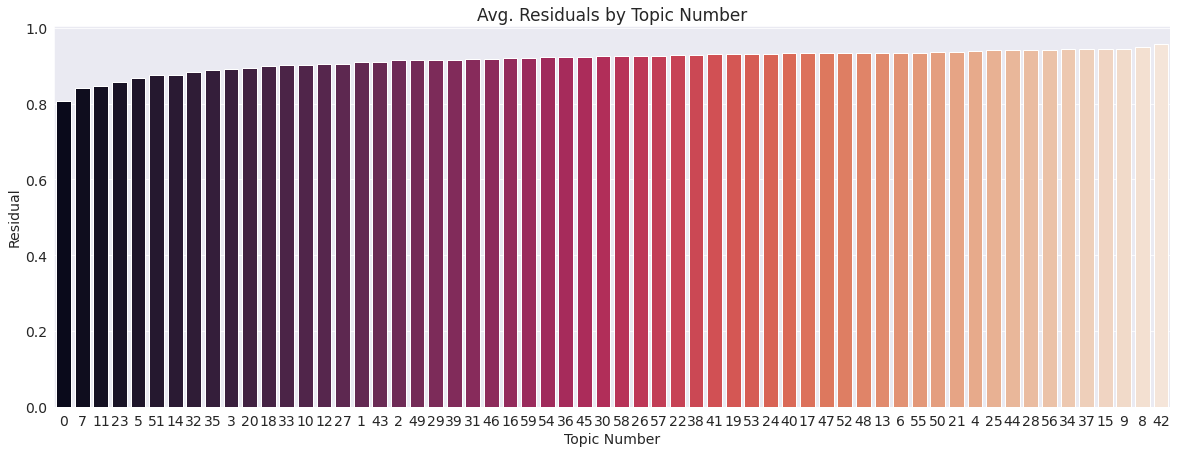

In [ ]:
# Add the residuals to the df
df_topics['resid'] = r

# Get the avg residual by topic
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)

file_name = 'avg_resid'

#fig.savefig(
    #file_path + file_name + '.png',
    #dpi=fig.dpi,
    #bbox_inches='tight'
#)

plt.show()

In [ ]:
topic_df.to_csv('/content/drive/MyDrive/yelp_dataset/topic_df.csv')

In [ ]:
df_topics.to_csv('/content/drive/MyDrive/yelp_dataset/df_topics.csv')

In [ ]:
resid_data.to_csv('/content/drive/MyDrive/yelp_dataset/resid_data.csv')

In [ ]:
df_topics

,Unnamed: 0,Unnamed: 0.1,business_id,city,state_x,user_id,review_stars,useful_x,text,date,useful_y,fans,Smogscore,review_word_count,Polarity,Analysis_TextBlob,Vader Sentiment,Vader Analysis,fips,cases,deaths,label,word_count,resid,topic_num,topics
0,0,0,uexKxrLmPO5iaXRT9TvWqQ,Portland,OR,1eSNY9Csb9ajO7__ci2vTA,3.0,0.0,Yes I am a fan of the food Ive tried more ...,2019-01-01,0.0,0.0,13.4,251.0,0.050208,Positive,0.7723,Positive,0.0,0.0,0.0,1.0,268,0.928888,47,portland visit favorit stop trip place restaur
1,1,1,b4PgITSqSWoPhyJ-Mjko7Q,Portland,OR,KYCpm1B9eIIgbPatCIcVkg,4.0,0.0,Im not a bubble tea connoisseur but Ive had it...,2019-01-01,328.0,6.0,0.0,46.0,0.263889,Positive,0.8519,Positive,0.0,0.0,0.0,1.0,48,0.873437,11,tea boba milk bubbl sweet sugar
2,2,2,2EJpVjliJ6Ceijbz9HSpeQ,Portland,OR,f1lLNjrLk4ETU2t_N7fHbA,5.0,1.0,Fantastic authentic Italian food the pinsa ha...,2019-01-01,8.0,0.0,12.2,74.0,0.360000,Positive,0.9307,Positive,0.0,0.0,0.0,1.0,75,0.938841,3,pizza crust slice best pie pepperoni place good
3,3,3,7m_Tj6xC5CjulQ-6Wucdpw,Portland,OR,uOSQbOnLRlAuWfCSCwQFnA,5.0,0.0,Good food very authentic The owner is pretty f...,2019-01-01,1.0,0.0,6.4,16.0,0.425000,Positive,0.9169,Positive,0.0,0.0,0.0,1.0,16,0.926724,19,veri good friend food nice tasti staff
4,4,4,DgvT9AiuePR8Z0SKV5BFvw,Portland,OR,bSTMk_GXsPE93COgqUDnMg,4.0,0.0,The service is outstanding and the pasta is go...,2019-01-01,0.0,0.0,8.8,39.0,0.450000,Positive,0.9217,Positive,0.0,0.0,0.0,1.0,39,0.896940,45,salad lunch dress fresh caesar bowl green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197944,197944,197944,BO4Usu_YSE7jlmchGMeVcw,Boston,MA,d3-SRpRr8SX2TZNOv4_dqg,4.0,0.0,I have to admit Shin Hakata Ramen was truly im...,2021-01-28,2.0,0.0,10.1,45.0,0.650000,Positive,0.9755,Positive,25025.0,70398.0,1548.0,1.0,45,0.925407,57,spot favorit hit new great neighborhood
197945,197945,197945,-WG2sv6ApNh1fa7ot-QAEA,Boston,MA,VZDjY7dU8gmraqr3oRCj-A,5.0,0.0,The BEST Rueben in Boston Hands down And I hav...,2021-01-28,1.0,0.0,6.4,27.0,0.250000,Positive,0.4995,Neutral,25025.0,70398.0,1548.0,1.0,27,0.960826,34,tri menu place everyth look want ive
197946,197946,197946,EbUZhM4fLpsWQ8fpBhhgEQ,Boston,MA,RcAvNzBP3e9TxZZpfpohOA,5.0,0.0,Mike Pattys is such a cool neighborhood gem I...,2021-01-28,0.0,0.0,10.8,42.0,0.242857,Positive,0.9521,Positive,25025.0,70398.0,1548.0,1.0,43,0.963307,36,breakfast egg brunch toast biscuit burrito bac...
197947,197947,197947,IqyqfQFnBsOIReGrcgaYhA,Boston,MA,DJctK3XMg_8-zFZYY8puKA,2.0,0.0,Store is a little hard to find since it is hid...,2021-01-28,1.0,0.0,0.0,32.0,-0.038889,Negative,0.1761,Neutral,25025.0,70398.0,1548.0,1.0,32,0.967051,41,nice veri super realli place atmospher littl
